# 3D Sphere, toy example

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
pi = np.pi
cos = np.cos
sin = np.sin

In [2]:
def uv_to_xyz(u, v):
    # u: 0 to 2pi
    # v: 0 to pi
    u = u * pi / 180.0
    v = v * pi / 180.0
    xx = np.outer(cos(u), sin(v)).item()
    yy = np.outer(sin(u), sin(v)).item()
    zz = np.outer(np.ones(np.size(u)), cos(v)).item()
    return np.array([xx, yy, zz])


In [3]:
def get_points(query_u):
    """Not using yet

    Args:
        query_u (_type_): _description_

    Returns:
        _type_: _description_
    """
    img_v_gap = 10
    I_e = torch.tensor(np.vstack([
        uv_to_xyz(u=0, v=30+3*img_v_gap),
        uv_to_xyz(u=0, v=30+2*img_v_gap),
        uv_to_xyz(u=0, v=30+1*img_v_gap),
        uv_to_xyz(u=0, v=30+0*img_v_gap),
    ]))

    txt_v_gap = 10
    T_e = torch.tensor(np.vstack([
        uv_to_xyz(u=query_u, v=30+3*txt_v_gap),
        uv_to_xyz(u=query_u, v=30+1*txt_v_gap),
        uv_to_xyz(u=query_u, v=30+2*txt_v_gap),
        uv_to_xyz(u=query_u, v=30+0*txt_v_gap),
    ]))
    return I_e, T_e

logit_scale 1
logit_scale 5
logit_scale 35
logit_scale 50
logit_scale 100


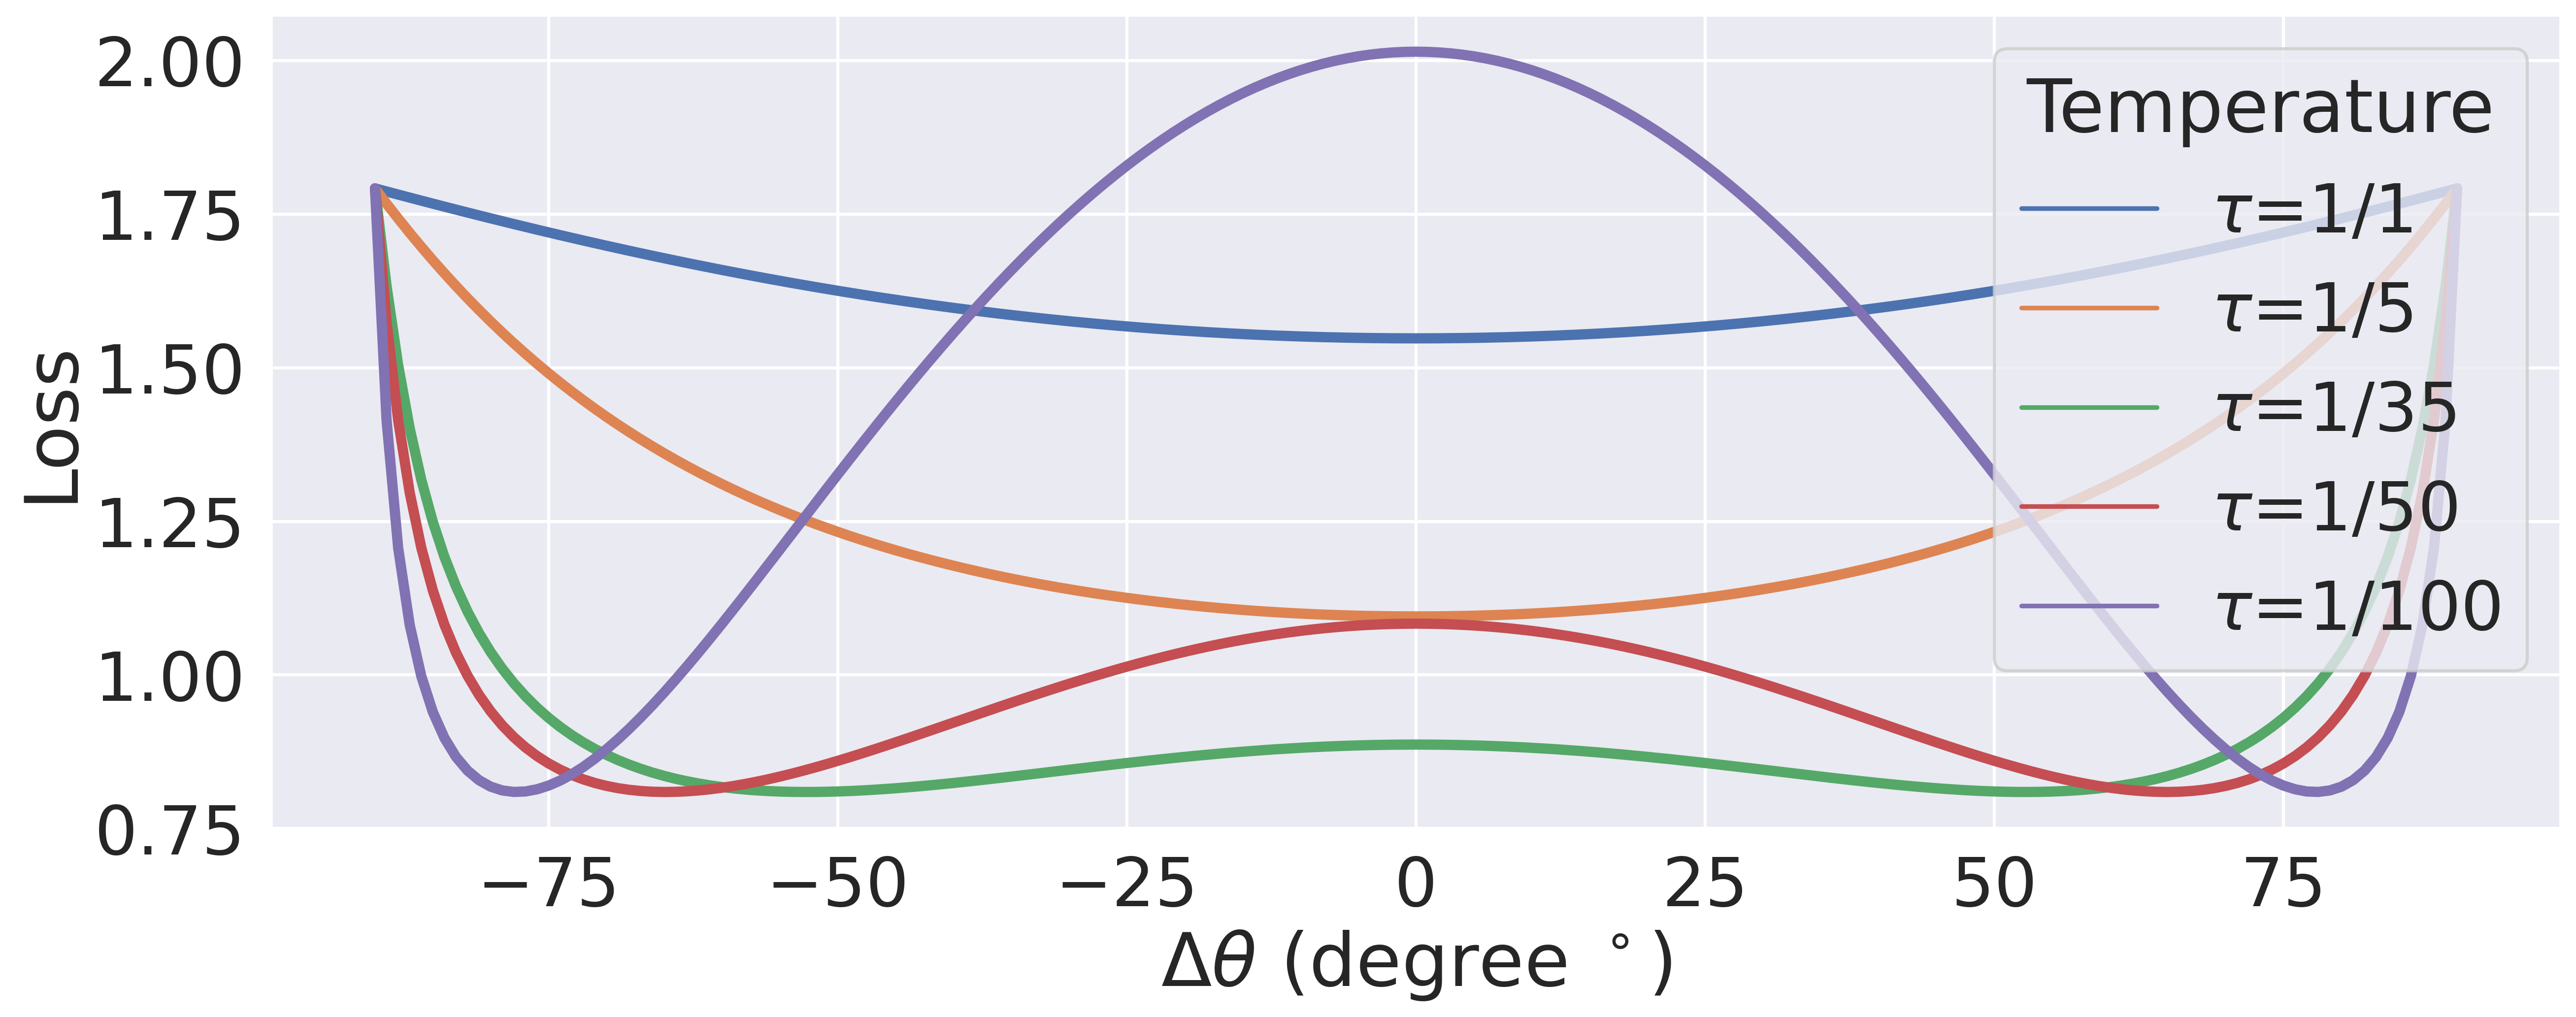

In [4]:
def get_clip_loss(I_e, T_e, logit_scale = 100.0):
    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    # logits = torch.mm(I_e, T_e.T) * logit_scale
    logits = I_e @ T_e.T * logit_scale

    BATCH_SIZE = len(I_e)
    # symmetric loss function
    labels = torch.arange(BATCH_SIZE,dtype=torch.long)
    loss_i = loss_img(logits, labels)
    loss_t = loss_txt(logits.T, labels)
    total_loss = (loss_i + loss_t)/2
    return total_loss.item()

all_results_list = list()
for logit_scale in [1, 5, 35, 50, 100]: # [100]: # 
    results_cache = defaultdict(list)
    for query_u in np.arange(90,-90-0.001, -1): # range(30, -30-0.001, -0.2):

        baseline_v = 90
        u_gap = 20
        I_e = torch.tensor(np.vstack([
            uv_to_xyz(u=-1*u_gap, v=baseline_v),
            uv_to_xyz(u=0*u_gap, v=baseline_v),
            uv_to_xyz(u=1*u_gap, v=baseline_v),
            uv_to_xyz(u=2*u_gap, v=baseline_v),
            uv_to_xyz(u=3*u_gap, v=baseline_v),
            uv_to_xyz(u=4*u_gap, v=baseline_v),
        ]))

        T_e = torch.tensor(np.vstack([
            uv_to_xyz(u=0*u_gap, v=baseline_v+query_u),
            uv_to_xyz(u=-1*u_gap, v=baseline_v+query_u),
            uv_to_xyz(u=1*u_gap, v=baseline_v+query_u),
            uv_to_xyz(u=2*u_gap, v=baseline_v+query_u),
            uv_to_xyz(u=3*u_gap, v=baseline_v+query_u),
            uv_to_xyz(u=4*u_gap, v=baseline_v+query_u),
        ]))


        # img_v_gap = 10
        # base_v = 60
        # I_e = torch.tensor(np.vstack([
        #     uv_to_xyz(u=0, v=base_v+3*img_v_gap),
        #     uv_to_xyz(u=0, v=base_v+2*img_v_gap),
        #     uv_to_xyz(u=0, v=base_v+1*img_v_gap),
        #     uv_to_xyz(u=0, v=base_v+0*img_v_gap),
        #     uv_to_xyz(u=0, v=base_v-1*img_v_gap),
        #     uv_to_xyz(u=0, v=base_v-2*img_v_gap),
        # ]))

        # txt_v_gap = img_v_gap
        # T_e = torch.tensor(np.vstack([
        #     uv_to_xyz(u=query_u, v=base_v+3*txt_v_gap),
        #     uv_to_xyz(u=query_u, v=base_v+2*txt_v_gap),
        #     uv_to_xyz(u=query_u, v=base_v+1*txt_v_gap),
        #     uv_to_xyz(u=query_u, v=base_v-1*txt_v_gap),
        #     uv_to_xyz(u=query_u, v=base_v-0*txt_v_gap),
        #     uv_to_xyz(u=query_u, v=base_v-2*txt_v_gap),
        # ]))


        # Euclidean distance between mass centers
        I_e_np = I_e.detach().numpy()
        T_e_np = T_e.detach().numpy()
        distance = np.linalg.norm(
            I_e_np.mean(axis=0) - T_e_np.mean(axis=0)
            ) * np.sign(query_u)


        clip_loss = get_clip_loss(I_e, T_e, logit_scale = logit_scale)
        # print('query_u', query_u, '\t', 'clip_loss', clip_loss)
        results_cache['query_u'].append(query_u)
        results_cache['Loss'].append(clip_loss)
        results_cache['Distance'].append(distance)
        results_cache['Temperature'].append( r'$\tau$=1/{}'.format(int(logit_scale)) )


    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import seaborn as sns

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    sns.set_theme()

    all_results_list.append(pd.DataFrame(results_cache))
    print('logit_scale', logit_scale)
    # plt.figure()
    # sns.lineplot(
    #     data=pd.DataFrame(results_cache),
    #     x='query_u', 
    #     # x='Distance', 
    #     y='Loss',
    #     marker="o"
    # )
    # plt.xlabel(r'$\phi$ (degree $^\circ$)')
    # plt.ylabel('Loss')
    # plt.show()


##########
sns.set_context("talk", font_scale=2 ) # paper, notebook, talk, and poster; font_scale=1.5,

plt.figure(figsize=(20,7.3))
sns.lineplot(
    data=pd.concat(all_results_list, ignore_index=True),
    x='query_u', 
    # x='Distance', 
    y='Loss',
    hue='Temperature',
    linewidth = 5.0,
    # marker="o"
)
plt.xlabel(r'$\Delta \theta$ (degree $^\circ$)')
plt.ylabel('Loss')
# Put the legend out of the figure
# plt.legend(title='Temperature', bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.)
plt.show()



# 3D plot: simulation setup

In [5]:
import qutip # QuTiP: Quantum Toolbox in Python

In [6]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_theme()
sns.set_context("talk", font_scale=1.5 ) # paper, notebook, talk, and poster; font_scale=1.5,

In [7]:
print(sns.color_palette())
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

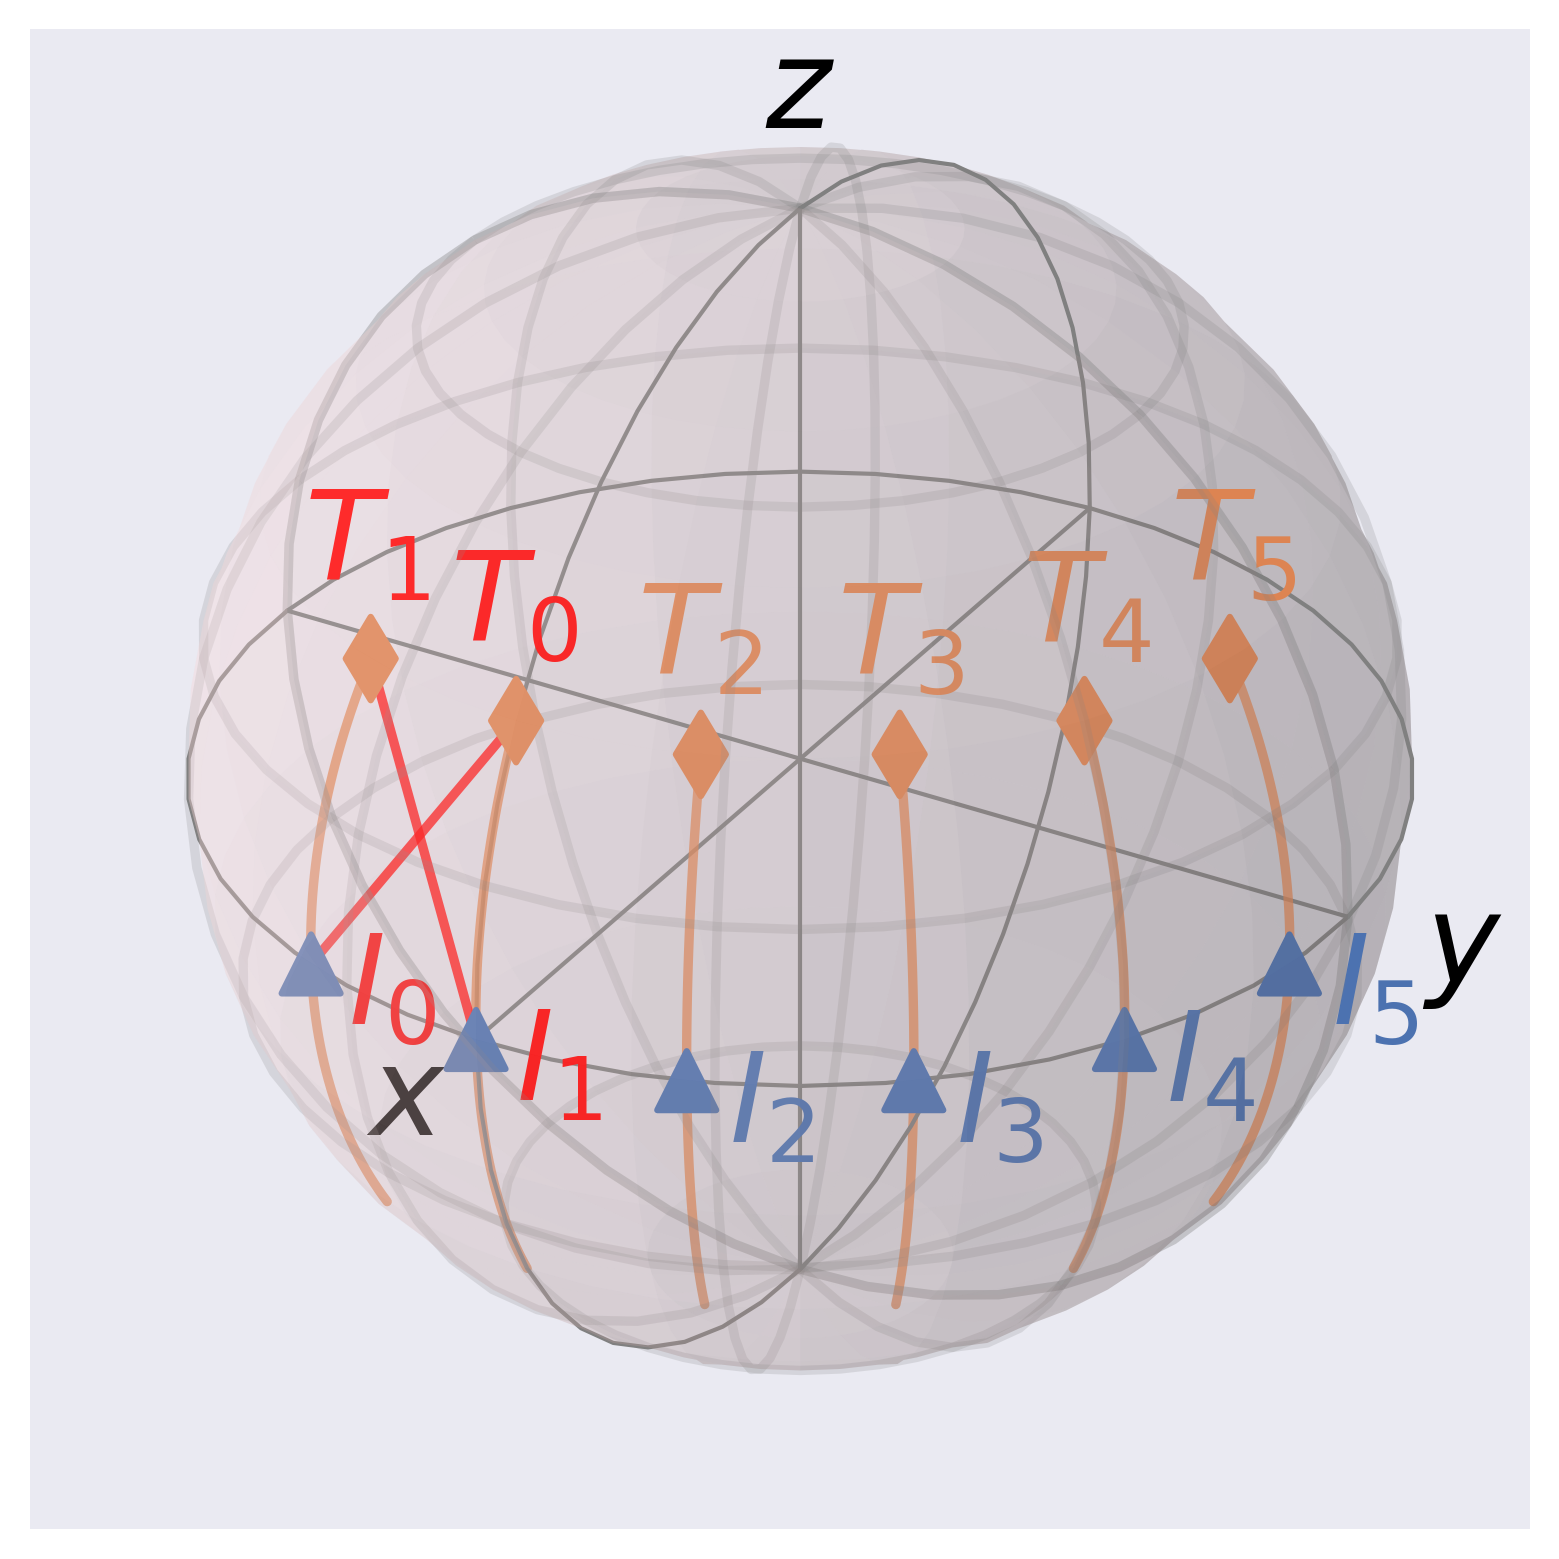

In [8]:
b = qutip.Bloch()
b.make_sphere()

b.point_size = [200]
b.font_size  = 30 #20
#### Point color list
orange_color = '#dd8452'
blue_color = '#4c72b0'
b.point_color = []



baseline_v = 90
u_gap = 20

#### Draw lines
T_e_list = list()
for query_u in np.arange(30,-30-0.001, -1):
    T_e = np.vstack([
        uv_to_xyz(u=0*u_gap, v=baseline_v+query_u),
        uv_to_xyz(u=-1*u_gap, v=baseline_v+query_u),
        uv_to_xyz(u=1*u_gap, v=baseline_v+query_u),
        uv_to_xyz(u=2*u_gap, v=baseline_v+query_u),
        uv_to_xyz(u=3*u_gap, v=baseline_v+query_u),
        uv_to_xyz(u=4*u_gap, v=baseline_v+query_u),
    ])
    T_e_list.append(T_e)

T_e_list = np.concatenate(T_e_list, axis=0)
batch_size = 6
for i in range(batch_size):
    b.add_points([T_e_list[i::batch_size,0], T_e_list[i::batch_size,1], T_e_list[i::batch_size,2]], meth='l') # plot trajectory line
    b.point_color.append(orange_color)

### Add the starting points for texts
T_e = T_e_list[-batch_size:]
b.add_points([T_e_list[-batch_size:,0], T_e_list[-batch_size:,1], T_e_list[-batch_size:,2]], meth='s') # draw points
b.point_color.append(orange_color)
### Annotate texts
for i in range(batch_size):
    color = 'red' if i<=1 else orange_color
    b.add_annotation([T_e[i,0], T_e[i,1], T_e[i,2] + 0.20], text=r'$T_{}$'.format(i), color=color )


### Add the starting points for images
I_e = np.vstack([
    uv_to_xyz(u=-1*u_gap, v=baseline_v),
    uv_to_xyz(u=0*u_gap, v=baseline_v),
    uv_to_xyz(u=1*u_gap, v=baseline_v),
    uv_to_xyz(u=2*u_gap, v=baseline_v),
    uv_to_xyz(u=3*u_gap, v=baseline_v),
    uv_to_xyz(u=4*u_gap, v=baseline_v),
])
b.add_points([I_e[:,0], I_e[:,1], I_e[:,2]], meth='s') # draw points
b.point_color.append(blue_color)
### Annotate images
for i in range(batch_size):
    color = 'red' if i<=1 else blue_color
    b.add_annotation([I_e[i,0], I_e[i,1] + 0.15, I_e[i,2]], text=r'$I_{}$'.format(i), color=color)

### Draw red lines (wrong annotation)
for i in [0,1]: # the wrong idx
    tmp = np.vstack([I_e[i], T_e[i]])
    b.add_points([tmp[:,0], tmp[:,1], tmp[:,2]], meth='l') # draw line
    b.point_color.append("red")


b.set_label_convention("xyz")
b.show()

